In [13]:
!pip install geomle
!pip install mnist
!pip install emnist

In [1]:
import sys
import os
from os import path
current_folder = path.dirname(path.abspath('')) 
sys.path.append(current_folder)
from estimators import *
from geomle import geomle, mle, DataGenerator
import multiprocessing as mp
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import cholesky
from scipy.special import gammainc, lambertw
from sklearn.datasets import fetch_openml
import mnist as mnist_api
import emnist as emnist_api
import scipy.io
import matplotlib as mpl
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import random
import time
import numpy as np
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
from functools import wraps
import subprocess
from IPython.display import display_html
from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)
rpy2.robjects.numpy2ri.activate()
utils = rpackages.importr('utils')
#utils.install_packages('intrinsicDimension')
#utils.install_packages('ider')
intdimr = rpackages.importr('intrinsicDimension')
ider   = rpackages.importr('ider')
r_base = rpackages.importr('base')

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def mean_sqe(estimations, truth):
    '''
    Mean squared error 
    '''
    return ((estimations - truth)^2/truth).sum() /len(truth) 
    
def mean_pe(estimations, truth):
    '''
    Mean percentage error 
    '''
    return (abs(estimations - truth)/truth).sum() /len(truth)*100

def mean_ge(estimations, truth):
    '''
    Mean geometric error: The geometric mean of the error *ratio*. It is always >= 1.
    '''
    ratios = np.concatenate(((estimations/truth)[np.newaxis, :], (truth/estimations)[np.newaxis, :]), axis=0)
    return np.power(ratios.max(axis=0).prod(), 1.0/len(estimations))

def med_pe(estimations, truth):
    '''
    Median error in %.
    '''
    return np.percentile(abs(estimations - truth)/truth, q=50)*100


def randball(n_points,ndim,radius,center = []):
    ''' Generate uniformly sampled ndim-sphere interior'''
    if center == []:
        center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def proxy(tup):
    function,X,Dict = tup
    return function(X,**Dict)

def get_nn(X,k,n_jobs=1):
    neigh = NearestNeighbors(n_neighbors=k,n_jobs=n_jobs)
    neigh.fit(X)
    dists, inds = neigh.kneighbors(return_distance=True)
    return dists,inds

def asPointwise(data,function, params, precomputed_knn = None, n_neighbors=100, n_jobs=1):
    '''Use a global estimator as a pointwise one by creating kNN neighborhoods'''
    if precomputed_knn is not None:
        knn = precomputed_knn
    else:
        _, knn = get_nn(data, k=n_neighbors, n_jobs=n_jobs)
        
    if n_jobs > 1:
        pool = mp.Pool(n_jobs)
        results = pool.map(proxy,[(function,data[i,:],params) for i in knn])
        pool.close()
        return results
    else:
        return [function(data[i,:],**params) for i in knn]


from functools import wraps
def calculate_time(func): 
    @wraps(func)
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'FastDANCo', 'ESS', 'PCA', 'CD','FisherS','ANOVA','TwoNN']
        self.caldatas = {}
        
    def estimateAllMethods(self, data,ConditionalNumber=10):
        dim = data.shape[1]
        self.funcs = {'MLE':          self.mle(data),
                      #'GeoMLE':       self.geomle(data, dim),
                      #'DANCo':        self.danco(data, dim),
                      'FastDANCo':    self.fast_danco(data),
                      #'ESS':          self.ess(data),
                      'PCA':          self.pca(data),
                      #'CD':           self.cd(data),
                      'FisherS':      self.fisherS(data,ConditionalNumber),
                      'ANOVA':        self.anova(data),
                      'TwoNN':        self.twonn(data)
                     }
                      
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    def estimateAllMethodsLocally(self, data, k, n_jobs = 1, ConditionalNumber = 10):
        dim = data.shape[1]
        
        _, knn = get_nn(data, k, n_jobs)
        
        mle_pw, tle_pw, mom_pw, ed_pw, ged_pw, pca_pw, mind_mlk_pw, mind_mli_pw = self.rado_ests(data,k).values()
        self.funcs = {'MLE':           self.mlelocal(data,k),
                      #'GeoMLE':        self.geomlelocal(data, dim),
                      #'mind_mlk':          asPointwise(data,self.mind_mlk,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      #'mind_mli':          asPointwise(data,self.mind_mli,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      #'DANCo':         asPointwise(data,self.danco,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      'FastDANCo':     self.fast_dancoloop(data),
                      'ESS':           asPointwise(data,self.ess,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'PCA':           asPointwise(data,self.pca,{},precomputed_knn=knn,n_jobs=1),
                      'CD':            asPointwise(data,self.lcd,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'FisherS':       asPointwise(data,self.fisherS,{'ConditionalNumber':ConditionalNumber},precomputed_knn=knn,n_jobs=n_jobs),
                      'FisherSglobpw': self.fisherS(data,ConditionalNumber,global_pw=True),
                      'ANOVA':         self.anovalocal(data,k),
                      'TwoNN':         asPointwise(data,self.twonn,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'radoMLE':       mle_pw,
                      'radoTLE':       tle_pw,
                      'radoMOM':       mom_pw,
                      'radoED':        ed_pw,
                      'radoGED':       ged_pw,
                      'radoPCA':       pca_pw,
                      'radoMINDmlk':   mind_mlk_pw,
                      'radoMINDmli':   mind_mli_pw,

                     }
                      
        self.times = {}
        for key, val in self.funcs.items():
            if key in ['MLE','ANOVA','FastDANCo','FisherSglobpw']:
                self.funcs[key] = np.array(val[0])
                self.times[key] = val[1]
            elif 'rado' in key:
                self.funcs[key] = np.array(val)
            else:
                self.funcs[key] = np.array([i[0] for i in val])
                self.times[key] = np.sum([i[1] for i in val])
            
        return self.funcs, self.times
    
    
    @staticmethod
    def rado_ests(data,k):
        return radovanovic_estimators_matlab(data,k=k)
    
    @staticmethod
    @calculate_time
    def mle(data):
        return intdimr.maxLikGlobalDimEst(data,k=20).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def mlelocal(data,k):
        res = intdimr.maxLikPointwiseDimEst(data,k=k)
        return np.array([i[0] for i in res])

    @staticmethod
    @calculate_time
    def geomle(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(pd.DataFrame(data), k1=20, k2=55, nb_iter1=1, alpha=5e-3).mean()

    @staticmethod
    @calculate_time
    def geomlelocal(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(pd.DataFrame(data), k1=20, k2=55, nb_iter1=1, alpha=5e-3)
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="MIND_MLk").rx2('dim.est')[0]
    

    @staticmethod
    @calculate_time
    def mind_mli(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="MIND_MLi").rx2('dim.est')[0]
    
    #@staticmethod
    @calculate_time
    def danco(self,data, dim):
        try:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), calibration_data = self.caldatas[len(data)], ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]
        except:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]

    @staticmethod
    @calculate_time
    def fast_danco(data):
        return runDANCo(data)[0]
    
    @staticmethod
    @calculate_time
    def fast_dancoloop(data):
        return runDANColoop(data)
    
    @staticmethod
    @calculate_time
    def ess(data):
        return ess_py(data)[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO', alphaFO = .1).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def cd(data):
        return corint_py(data, k1=10, k2=20)[0]
    
    @staticmethod
    @calculate_time
    def lcd(data):
        return corint_py(data, k1=10, k2=len(data)-1)[0]
    
    @staticmethod
    @calculate_time
    def fisherS(data,ConditionalNumber,global_pw=False):
        if global_pw:
            n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp = SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None],ConditionalNumber=ConditionalNumber)
            n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected',force_definite_dim=False,verbose=False)
            return n_pointwise
        else:
            return SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None],ConditionalNumber=ConditionalNumber)[1][0]
    
    @staticmethod
    @calculate_time
    def anova(data):
        return runANOVAglobal(data)[0,0]
    
    @staticmethod
    @calculate_time
    def anovalocal(data,k):
        return runANOVAlocal(data,k=k)[:,0]
    
    @staticmethod
    @calculate_time
    def twonn(data):
        res = twonn_py(data)
        return res    

# Real data (each dataset is loaded and subsampled to max(cardinality,5000)

In [3]:
DE=DimEst()

#### Datasets from Tight locality estimation paper

In [ ]:
data_files = list(filter(lambda x: '.data' in x and 'mnist' not in x, os.listdir('../data/id-tle-real-data/data/real/')))
real_data = [np.array(pd.read_csv('../data/id-tle-real-data/data/real/'+file,sep=' ',header=None)) for file in data_files]
real_data = dict(zip(data_files,real_data))

In [ ]:
# gisette: handwritten digits (4 and 9) 2 classes
# msd: songs by various (mostly western) singers spanning several decades 90 classes
# aloi: Amsterdam Library of Object Images 1000 classes
# covertype: forest cover type (features: wilderness area, soil types) 7 classes
# isolet: 150 subjects spoke the name of each letter of the alphabet twice 26 classes
# ann_sift1b: 3·10^7 classes
# bci5: 3 classes

In [5]:
print('Real datasets used in Intrinsic Dimensionality Estimation within Tight Localities:\n')
for key,_data in real_data.items():
    print(key+'\t'+str(_data.shape))

Real datasets used in Intrinsic Dimensionality Estimation within Tight Localities:

gisette.data	(7000, 5000)
msd.data	(515345, 90)
ann_sift1b.data	(1000000, 128)
aloi.data	(110250, 641)
covertype.data	(581012, 56)
isolet.data	(7797, 617)
bci5.data	(31216, 96)


#### MNIST variants and isomapFaces

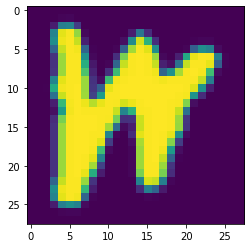

In [6]:
letters, emnist_labels = emnist_api.extract_training_samples('letters')
emnist = letters.reshape((len(letters),-1))
plt.imshow(letters[0])

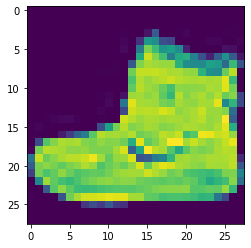

In [7]:
fashion_mnist=fetch_openml(name="Fashion-MNIST",data_home="../data")
fmnist = fashion_mnist['data']
fmnist_labels = fashion_mnist['target']
plt.imshow(fmnist[0].reshape(28,28))

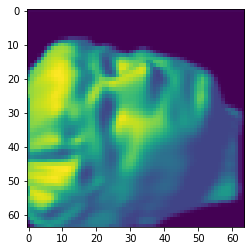

In [22]:
isomapFaces = scipy.io.loadmat('../data/face_data.mat')['images'].T
plt.imshow(isomapFaces[0].reshape((64,64)))

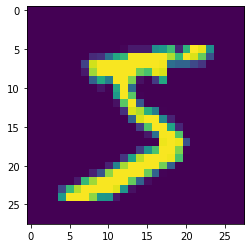

In [9]:
train_images, test_images = mnist_api.train_images(), mnist_api.test_images()
train_labels, test_labels = mnist_api.train_labels(), mnist_api.test_labels()

mnist = np.concatenate((train_images,test_images))
mnist = mnist.reshape((mnist.shape[0],-1))
mnist_labels = np.concatenate((train_labels,test_labels))

plt.imshow(train_images[0])

In [ ]:
# add datasets to the common dict
real_data['MNIST']=mnist
real_data['EMNIST']=emnist
real_data['FMNIST']=fmnist
real_data['isomapFaces']=isomapFaces

## Generate subsampled datasets

In [ ]:
subsample_size = 5000

real_data_subsampled = {}
real_data_subsampled_idx = {}


for key,_data in real_data.items():
    dataset_name = key
    full_n_samples = _data.shape[0]
    
    
    if full_n_samples > subsample_size:
        #define reproducible subsample index
        np.random.seed(0);subsample = np.random.choice(full_n_samples,replace=False, size=subsample_size)
        
        real_data_subsampled[key] = _data[subsample]
        real_data_subsampled_idx[key] = subsample
    else:
        real_data_subsampled[key] = _data
        real_data_subsampled_idx[key] = None
        
        
with open('../data/real_data_subsampled.pkl','wb') as f:
    pickle.dump(real_data_subsampled,f)
with open('../data/real_data_subsampled_idx.pkl','wb') as f:
    pickle.dump(real_data_subsampled_idx,f)

# Load subsampled datasets, run 

In [4]:
#load subsampled datasets
with open('../data/real_data_subsampled.pkl','rb') as f:
    real_data_subsampled = pickle.load(f)
with open('../data/real_data_subsampled_idx.pkl','rb') as f:
    real_data_subsampled_idx = pickle.load(f)
    
for k,v in real_data_subsampled.items():
    print(k,v.shape)

gisette.data (5000, 5000)
msd.data (5000, 90)
ann_sift1b.data (5000, 128)
aloi.data (5000, 641)
covertype.data (5000, 56)
isolet.data (5000, 617)
bci5.data (5000, 96)
MNIST (5000, 784)
EMNIST (5000, 784)
FMNIST (5000, 784)
isomapFaces (698, 4096)


In [5]:
# remove gisette dataset (fisherS produces errors: all points are separable for localID)
del real_data_subsampled['gisette.data']

### Global ID saturation analysis

In [6]:
# testing separability saturation
n_repeats = 10
n_methods = 6
all_sample_sizes = [1,2,4,8,10,20,40,60,80]

#for key,data in real_data_subsampled.items():
for key,data in real_data_subsampled.items():
    
    datasets_done = [i.split('_')[0] for i in list(filter(lambda x: '.data' in x, os.listdir('../results')))]
    dataset_name = key
    n_samples = data.shape[0]
    
    if dataset_name in datasets_done:
        print('already computed ', dataset_name)
        continue
    
    print('\n',dataset_name)
    print('Running subsampling analysis...\nSubsample percentages = {}\nNumber of repeats = {}\nNumber of samples = {}\nDimension = {}'.format(all_sample_sizes,n_repeats,n_samples,data.shape[1]))
    print('----------------------------\n')
    seed = 0; np.random.seed(seed)
    print(f'Random seed set to {seed} before running the test')
    
    all_dim_estimates = np.zeros([n_methods,len(all_sample_sizes)+1,n_repeats])

    runtimes = []
    for i,sz in enumerate(all_sample_sizes):
        if dataset_name == 'isomapFaces' and sz < 8:
            print(f'subsample {sz} is too small for isomapFaces dataset. continue')
            continue

        sample_size = int(n_samples*sz/100)
        print('Sample size = {}'.format(sample_size))
        start_time = time.time()
        for j in range(0,n_repeats):
            sample = np.random.choice(n_samples,replace=False, size=sample_size)
            xs = data[sample,:]

            #Run estimators
            allres = DE.estimateAllMethods(xs)
            results = allres[0]
            runtimes.append(allres[1])

            #Store
            for it,key in enumerate(results.keys()):
                all_dim_estimates[it,i,j] =  results[key]


        print("Elapsed time = {}".format(time.time()-start_time))

    allres = DE.estimateAllMethods(data)
    results = allres[0]
    runtimes.append(allres[1])

    for i in range(0,n_repeats):
        for it,key in enumerate(results.keys()):
            all_dim_estimates[it,len(all_sample_sizes),i] =  results[key]

    with open("../results/"+dataset_name+"_all_dim_estimates.npy",'wb') as f:
        pickle.dump(all_dim_estimates,f)
        
all_sample_sizes.append(100)
np.savetxt("../results/all_sample_sizes.txt", all_sample_sizes, delimiter="\t")
with open("../results/all_dim_estimates_keys.npy",'wb') as f:
        pickle.dump(list(results.keys()),f)


 msd.data
Running subsampling analysis...
Subsample percentages = [1, 2, 4, 8, 10, 20, 40, 60, 80]
Number of repeats = 10
Number of samples = 5000
Dimension = 90
----------------------------

Random seed set to 0 before running the test
Sample size = 50
Elapsed time = 68.62852001190186
Sample size = 100


KeyboardInterrupt: 

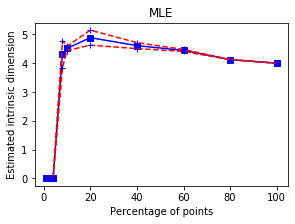

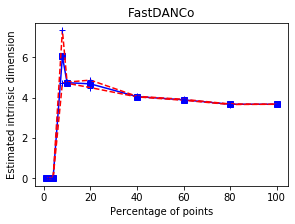

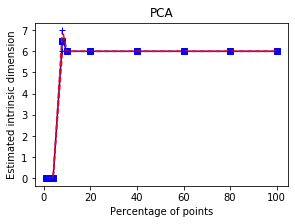

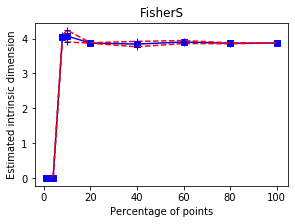

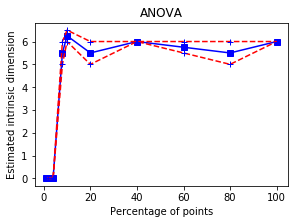

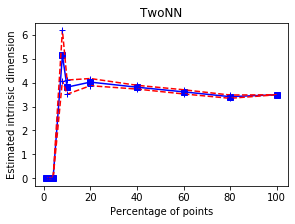

In [29]:
# plot convergence curve
alls=pd.read_csv('../results/all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]

with open("../results/"+dataset_name+"_all_dim_estimates.npy",'rb') as f:
    all_dim_estimates = pickle.load(f)
    
with open("../results/all_dim_estimates_keys.npy",'rb') as f:
    estimators = pickle.load(f)

for i,estimator in enumerate(estimators):
    dim_estimates = all_dim_estimates[i]
    
    mn = np.mean(dim_estimates[:,:],1)
    std = np.std(dim_estimates[:,:],1)

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.title(estimator)
    plt.plot(all_sample_sizes,mn,'bs-')
    plt.plot(all_sample_sizes,mn-std,'r--')
    plt.plot(all_sample_sizes,mn+std,'r--')
    plt.plot(all_sample_sizes,dim_estimates,'b+')
    plt.xlabel('Percentage of points')
    plt.ylabel('Estimated intrinsic dimension')

### Local estimates convergence

In [7]:
# testing separability saturation
n_jobs = 4
num_neighbors = num_neighbors = np.arange(50,450,50)
n_repeats = 10
n_methods = 18
all_sample_sizes = [1,2,4,8,10,20,40,60,80]


for n_neighbors in num_neighbors:

    #for key,data in real_data_subsampled.items():
    for key,data in real_data_subsampled.items():

        datasets_done = [i.split('_')[0] for i in list(filter(lambda x: '.data' in x, os.listdir('../results')))]
        dataset_name = key
        n_samples = data.shape[0]
        

        if dataset_name in datasets_done:
            print('already computed ', dataset_name)
            continue

        print('\n',dataset_name)
        print('Running subsampling analysis...\nSubsample percentages = {}\nNumber of repeats = {}\nNumber of samples = {}\nDimension = {}'.format(all_sample_sizes,n_repeats,n_samples,data.shape[1]))
        print('----------------------------\n')
        print('kNN = ',n_neighbors)
        seed = 0; np.random.seed(seed)
        print(f'Random seed set to {seed} before running the test')


        all_dim_estimates = np.zeros([n_methods,len(all_sample_sizes)+1,n_repeats,len(data)])

        runtimes = []
        for i,sz in enumerate(all_sample_sizes[4:]):
            
            sample_size = int(n_samples*sz/100)
            
            if sample_size <= 2*n_neighbors:
                print(f'Sample size {sample_size} too small for chosen neighborhood {n_neighbors}. continue')
                continue
            else:
                print('Sample size = {}'.format(sample_size))
            start_time = time.time()
            for j in range(0,n_repeats):
                sample = np.random.choice(n_samples,replace=False, size=sample_size)
                xs = data[sample,:]

                #Run estimators
                allres = DE.estimateAllMethodsLocally(xs, k = n_neighbors, n_jobs = n_jobs, ConditionalNumber = 10)

                results = allres[0]
                runtimes.append(allres[1])

                #Store
                for it,key in enumerate(results.keys()):
                    all_dim_estimates[it,i,j,:len(xs)] =  results[key]


            print("Elapsed time = {}".format(time.time()-start_time))

        allres = DE.estimateAllMethodsLocally(data, k = n_neighbors, n_jobs = n_jobs, ConditionalNumber = 10)

        results = allres[0]
        runtimes.append(allres[1])

        for i in range(0,n_repeats):
            for it,key in enumerate(results.keys()):
                all_dim_estimates[it,len(all_sample_sizes),i,:len(data)] =  results[key]

        with open("../results/"+dataset_name+"_all_dim_estimates_kNN"+str(n_neighbors)+".npy",'wb') as f:
            pickle.dump(all_dim_estimates,f)

with open("../results/"+dataset_name+"_all_dim_estimates_keys_kNN"++str(n_neighbors)+".npy",'wb') as f:
        pickle.dump(list(results.keys()),f)


 msd.data
Running subsampling analysis...
Subsample percentages = [1, 2, 4, 8, 10, 20, 40, 60, 80]
Number of repeats = 10
Number of samples = 5000
Dimension = 90
----------------------------

kNN =  50
Random seed set to 0 before running the test
Sample size = 500
Elapsed time = 379.82841753959656
Sample size = 1000


Process ForkPoolWorker-170:
Process ForkPoolWorker-171:
Traceback (most recent call last):
Process ForkPoolWorker-172:
  File "/home/utilisateur/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/utilisateur/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/utilisateur/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-169:
  File "/home/utilisateur/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/utilisateur/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/utilisateur/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File

KeyboardInterrupt: 

In [33]:
with open("../results/"+dataset_name+"_all_dim_estimates_kNN"+str(n_neighbors)+".npy",'rb') as f:
    res_pw=pickle.load(f)

In [ ]:
#np.random.seed(0);umap_emb = umap.UMAP().fit_transform(data)
#plt.scatter(umap_emb[:,0],umap_emb[:,1],c=real_data_subsampled_labels,cmap=plt.cm.Paired);plt.title('MNIST subsample');plt.colorbar();plt.show()
#plt.scatter(umap_emb[:,0],umap_emb[:,1],c=res_pw[0]['FisherS'],vmax=np.quantile(res_pw[0]['FisherS'],.99));plt.title('MNIST subsample local ID');plt.colorbar();plt.show()

In [26]:
#list_global_id = []
#list_pwglobal = []
#list_palphas = []
#for dataset_name,data in real_data:
#
#    print(dataset_name)
#    start_all=time.time()
#
#    [n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None], ConditionalNumber=10)
#    n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='selected',force_definite_dim=True,verbose=False)
#
#    list_global_id.append(n_single[0])
#    list_pwglobal.append(n_pointwise)
#    list_palphas.append(p_alpha)
#
#    print('elapsed :',round(time.time()-start_all,2))
#    
#    with open('../results/list_pwglobal_'+dataset_name+'.pkl','wb') as f:
#        pickle.dump(list_pwglobal,f)

In [25]:
#plt.scatter(umap_emb[:,0],umap_emb[:,1],c=real_data_subsampled_labels[:1000],cmap=plt.cm.Paired);plt.title('MNIST subsample');plt.colorbar();plt.show()
#plt.scatter(umap_emb[:,0],umap_emb[:,1],c=n_pointwise);plt.title('MNIST subsample local ID');plt.colorbar();plt.show()